In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.init as init
from torch.utils.data import DataLoader, IterableDataset
from PIL import Image, ImageDraw

In [ ]:
image_width = 200
image_height = 200

In [70]:
# load target image "lisa.png"
target_image = Image.open("../build/lisa.png")
assert target_image.size == (image_width, image_height)
target_image_np = (np.asarray(target_image).astype(np.float32) / 255.0)[:, :, 0:3]

In [ ]:
def unpack_color(col):
    return tuple(map(lambda i: max(0, min(255, int(i * 255.99))), col))

def rasterize_polygon(background, colours, shapes):
    image = Image.new("RGBA", (image_width, image_height))
    draw = ImageDraw.Draw(image)

    draw.polygon([(0, 0), (0, image_height), (image_width, image_height), (image_width, 0)],
                fill=unpack_color(background))

    for colour, shape in zip(colours, shapes):
        new_triangle = Image.new("RGBA", (image_width, image_height))
        tdraw = ImageDraw.Draw(new_triangle)
        tdraw.polygon([(x*image_width, y*image_height) for x, y in shape], fill=unpack_color(colour))

        image = Image.alpha_composite(image, new_triangle)
    
    return image

def generate_random_batch(batch_size, num_vertices, num_shapes):
    """Generate a batch of tensors representing collections of shapes, with each tensor having shapes with an RGBA colour and vertex positions, each on [0, 1]. Each tensor also includes a prepended RGB colour for the background."""
    inputs, targets = [], []
    for _ in range(batch_size):
        background = np.random.rand(3)
        colours = np.random.rand(num_shapes, 4)
        vertices = np.random.rand(num_shapes, num_vertices, 2)

        rasterized_image = rasterize_polygon(background, colours, vertices)
        rasterized_image_np = (np.asarray(rasterized_image).astype(np.float32) / 255.0)[:, :, 0:3]

        # compute the mse loss between the rasterized image and the target image
        loss = np.mean((rasterized_image_np - target_image_np) ** 2)

        inputs.append(np.concatenate([background, colours.flatten(), vertices.flatten()]))
        targets.append(loss)
    return torch.tensor(np.array(inputs), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)


In [136]:
class RandomPolygonDataset(IterableDataset):
    def __init__(self, num_batches, batch_size, num_vertices, num_shapes):
        self.num_batches = num_batches
        self.batch_size = batch_size
        self.num_vertices = num_vertices
        self.num_shapes = num_shapes

    def __iter__(self):
        for _ in range(self.num_batches):
            yield generate_random_batch(self.batch_size, self.num_vertices, self.num_shapes)
        return

In [232]:
batch_size = 128
num_batches = 64
dataset = RandomPolygonDataset(num_batches, batch_size, 3, 50)
data_loader = DataLoader(dataset, batch_size=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# model = nn.Sequential(
#     nn.Linear(3 + 50 * (3 * 2 + 4), 512), # 3 for RGB background + 50 shapes with 3 vertices each, and 4 for RGBA colour
#     nn.ReLU(),
#     nn.Linear(512, 512),
#     nn.ReLU(),
#     nn.Linear(512, 512),
#     nn.ReLU(),
#     nn.Linear(512, 512),
#     nn.ReLU(),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.hidden = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.hidden(x)
        return self.output(x)

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:  # Bias initialization (optional but often useful)
            init.zeros_(layer.bias)

model = MLP(3 + 50 * (3 * 2 + 4))
model = model.to(device)
model.apply(init_weights) # weight initialization


MLP(
  (encoder): Sequential(
    (0): Linear(in_features=503, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
  )
  (hidden): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [234]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [235]:
for epoch in range(1000):
    loss_aggregate = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs).squeeze()
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        loss_aggregate += loss.item()
        
    print(f"Epoch {epoch+1}, Mean Loss: {loss_aggregate / num_batches}")

Epoch 1, Mean Loss: 0.2292758326357216
Epoch 2, Mean Loss: 0.0011921821987925796
Epoch 3, Mean Loss: 0.001447140331947594
Epoch 4, Mean Loss: 0.0012840372355640284
Epoch 5, Mean Loss: 0.0010722774682108138
Epoch 6, Mean Loss: 0.0007402531737170648
Epoch 7, Mean Loss: 0.0010684706717256631
Epoch 8, Mean Loss: 0.0010455737838128698
Epoch 9, Mean Loss: 0.0006370122000589618
Epoch 10, Mean Loss: 0.000660729895116674
Epoch 11, Mean Loss: 0.0006136117144706077
Epoch 12, Mean Loss: 0.0005246650380286155
Epoch 13, Mean Loss: 0.0006242148024284688
Epoch 14, Mean Loss: 0.0007253055096043681
Epoch 15, Mean Loss: 0.000573115261431667
Epoch 16, Mean Loss: 0.0005550342616515991
Epoch 17, Mean Loss: 0.0005781802360615984
Epoch 18, Mean Loss: 0.0006205682593645179
Epoch 19, Mean Loss: 0.0005449858572319499
Epoch 20, Mean Loss: 0.0004008523828815669
Epoch 21, Mean Loss: 0.0004444908540790493
Epoch 22, Mean Loss: 0.0004350245249042928
Epoch 23, Mean Loss: 0.0005258392434370762
Epoch 24, Mean Loss: 0.000

KeyboardInterrupt: 

In [134]:
# time the generation of a batch of size 1000
from timeit import timeit
print(timeit(lambda: generate_random_batch(100, 3, 50), number=1))

0.1762701739990007


0.4917297015551509
y = 0.24214625410589732x + 0.07762109188560276


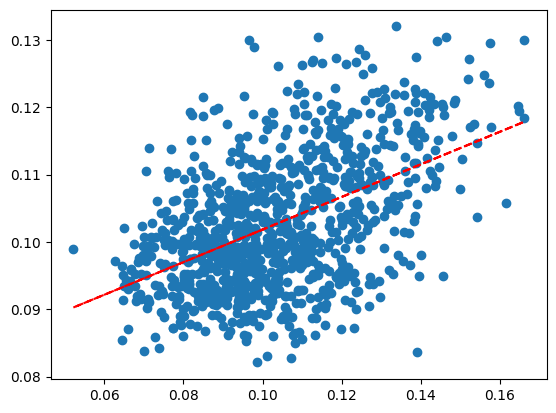

In [236]:
inputs, outputs = generate_random_batch(1000, 3, 50)
inputs, outputs = inputs.to(device), outputs.to(device)
model(inputs).squeeze(), outputs

outputs_np, predictions_np = outputs.cpu().detach().numpy(), model(inputs).squeeze().cpu().detach().numpy()

# plot model predictions against outputs
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(outputs_np, predictions_np)

# draw a correlation line
z = np.polyfit(outputs_np, predictions_np, 1)
p = np.poly1d(z)
plt.plot(outputs_np, p(outputs_np), "r--")

# print the correlation coefficient
print(np.corrcoef(outputs_np, predictions_np)[0, 1])

# print the line equation
print(f"y = {z[0]}x + {z[1]}")

In [263]:
inputs, outputs = generate_random_batch(1, 3, 50)
inputs = inputs.to(device)

# use gradient descent to optimize the input such that it minimizes the model's output
inputs.requires_grad = True
optimizer = optim.Adam([inputs], lr=1e-3)

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model(inputs).squeeze()
    loss.backward()
    optimizer.step()

    if loss.item() < 1e-4:
        break

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.09914054721593857
Epoch 100, Loss: 0.07273561507463455
Epoch 200, Loss: 0.04927991330623627


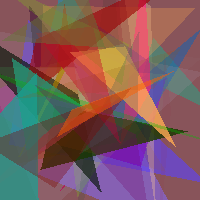

In [264]:
rasterize_polygon(inputs[0, 0:3].cpu().detach().numpy(), inputs[0, 3:3+50*4].reshape(50, 4).cpu().detach().numpy(), inputs[0, 3+50*4:].reshape(50, 3, 2))